# Focus of this Notebook:
Massive thanks to Gunes Evitan and his fantastic feature engineering tutorial, which was instrumental in the development of this notebook:
https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial

My notebook borrows a lot of the features from Gunes' tutorial, but in my notebook I try to emphasize model evaluation and diagnostics, which caused me the biggest headache during this project.
With this notebook, I will tell the story of how I solved this problem, and the challenges I faced along the way. I will be using the Data Science Methodology template coined by IBM's John Rollins as a guide for the problem solving process.
(https://www.ibmbigdatahub.com/blog/why-we-need-methodology-data-science)



# 1. Exploratory Data Analysis

Import the required libraries:

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


# 1.1 Data Collection:
Normally, this stage in the data science methodology would take a while, but because this is a convenient Kaggle competition, our data has been collected for us. 
Import the training and test data, and merge them into one dataframe. This will allow us to clean the training and test data together at once:

In [2]:
#import data
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
data = pd.concat([train,test]).reset_index(drop=True)
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


## 1.2 Data Understanding/Preparation:
### 1.2.1 Variable Types:
Let's take a look at what kind of information we are given in this dataset:

In [3]:
data.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

We are working with the following variable types:

Categorical/Nominal Variables:
* Survived (0 = didn't survive, 1 = survived)
* Pclass (1 = first class, 2 = second class, 3 = third class)
* Sex (male or female)
* Embarked (C = Cherbourg, S = Southampton, Q = Queenstown)

Ratio Variables:
* Age
* Fare 
* SibSp (number of siblings/spouses onboard with passenger)
* Parch (number of parents/children onboard with passenger)

String Variables:
* Name
* Ticket
* Cabin

### 1.2.2 Impute Missing Values:
Check to see how many missing values are in each feature:

In [4]:
data.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Let's take care of the low-hanging fruit. There are only 2 missing values in our Embarked variable. We can filter for these samples:

In [5]:
data[data.Embarked.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


From Encyclopedia Titanica, we know both Amelie Icard and Martha Evelyn Stone embarked from Southampton, so we can manually input missing embarkment data

In [6]:
data['Embarked'] = data['Embarked'].fillna('S')

There is a lot of missing Age data, so the way we impute missing Age data must be given careful thought. We can analyze the age distribution of passengers based on their class and sex:

In [7]:
data.groupby(['Pclass','Sex'])['Age'].median()

Pclass  Sex   
1       female    36.0
        male      42.0
2       female    28.0
        male      29.5
3       female    22.0
        male      25.0
Name: Age, dtype: float64

Text(0.5, 1.0, 'Age Distribution of Passengers based on Class')

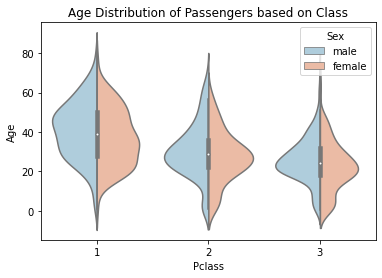

In [8]:
sns.violinplot(x='Pclass',y='Age',hue='Sex',data=data,split = True, palette = 'RdBu_r')
plt.title('Age Distribution of Passengers based on Class')

We can see from the violin plot that the age distributions by sex for the different passenger classes is quite different. We will therefore fill the missing age data by calculating the mean age for each sex, by passenger class:

In [9]:
def fill_age(df,age,sex,pclass):
    """This function finds all passengers with NaN age values, looks at the passengers class/sex,
    computes the mean age for passengers of the same class/sex, and
    populates the missing age with the mean age for that respective class/sex combination """
    for i in range(0,len(age)):
        if np.isnan(age[i]):
            age[i] = df.loc[(df.Sex == sex[i]) & (df.Pclass == pclass[i])].Age.median()

    df.Age = age
    return df    

In [10]:
age = list(data.Age)
pclass = list(data.Pclass)
sex = list(data.Sex)

#apply previously written function to populate missing age data
fill_age(data,age,sex,pclass)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,25.0,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,25.0,0,0,359309,8.0500,NaN,S


We can fill missing Fare information by simply calculating the mean fare for the passenger class of the missing sample:

In [11]:
def fill_fare(df,fare,pclass):
    """performs same job as fill_age, but populates missing fare data instead.
    Populates based on mean Pclass fare price."""
    for i in range(0,len(fare)):
        if np.isnan(fare[i]):
            fare[i] = df.loc[(df.Pclass == pclass[i])].Fare.mean()

    df.Fare = fare
    return df  

In [12]:
fare=list(data.Fare)
pclass=list(data.Pclass)

#apply previously written function to populate missing fare information
fill_fare(data,fare,pclass)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,25.0,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,25.0,0,0,359309,8.0500,NaN,S


The last variable we have to populate missing data for is the Cabin variable. There is a lot of missing data here, but it makes logical sense that there would be a relationship between what a passenger's cabin assignment and their survival.

The first character of the cabin number is useful to indicate what cabin each passenger was located in:

In [13]:
#analyze missing cabin data
#label any missing cabins as 'M'
data.Cabin = data.Cabin.fillna('M')

#export cabin numbers to a list to process
cabinlist = list(data.Cabin)

#loop through cabin lists, keeping only the first character 
#(the letter signifying the cabin the passenger is in)
for i in range(0,len(cabinlist)):
    if len(cabinlist[i]) > 1:
        cabinlist[i] = cabinlist[i][0]

#put modified list back in the dataframe
data.Cabin = cabinlist
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,M,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,M,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,M,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,25.0,0,0,A.5. 3236,8.0500,M,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,M,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,25.0,0,0,359309,8.0500,M,S


Text(0.5, 1.0, 'Survivor Breakdown by Cabin')

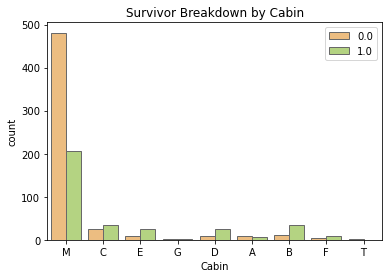

In [14]:
#visualize survivors in each cabin
sns.countplot('Cabin',hue='Survived',data=data, palette = 'RdYlGn',edgecolor = 'dimgrey')
plt.legend(loc='upper right')
plt.title('Survivor Breakdown by Cabin')

From the plot above, it's clear that different cabins have different survival rates. Below, we can see that we have no more missing variables (aside from the Survived feature for our test set):

In [15]:
data.isna().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
dtype: int64

## 1.3 Data Cleaning:
There is a lot of useful information we could deduce from the names of passengers. Their title indicates their marital status, role aboard the ship, and economic status. Let's break this variable down: 

In [16]:
#splits name into separate components to locate title
data['title'] = data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

#prints unique titles for all passengers aboard
set(data.title)

{'Capt',
 'Col',
 'Don',
 'Dona',
 'Dr',
 'Jonkheer',
 'Lady',
 'Major',
 'Master',
 'Miss',
 'Mlle',
 'Mme',
 'Mr',
 'Mrs',
 'Ms',
 'Rev',
 'Sir',
 'the Countess'}

In [17]:
#create a dictionary to bin passenger titles into more general categories
newtitles = {'Capt':'Officer','Col':'Officer','Don':'Officer','Dr':'Officer','Jonkheer':'Noble','Lady':'Noble',\
            'Major':'Officer','Master':'Master','Miss':'Miss','Mlle':'Mlle','Mme':'Mme','Mr':'Mr',\
            'Mrs':'Mrs','Ms':'Ms','Rev':'Officer','Sir':'Noble','the Countess':'Noble','Dona':'Miss'}
#assign new title to each passenger
data.title = data.title.map(newtitles)
data.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
1222,1223,NaN,1,"Dulles, Mr. William Crothers",male,39.0,0,0,PC 17580,29.7000,A,C,Mr
1023,1024,NaN,3,"Lefebre, Mrs. Frank (Frances)",female,22.0,0,4,4133,25.4667,M,S,Mrs
1302,1303,NaN,1,"Minahan, Mrs. William Edward (Lillian E Thorpe)",female,37.0,1,0,19928,90.0000,C,Q,Mrs


Now we see we've populated all of the missing data, and delved deeper into our dataset, we can go ahead and start to visualize the data to better understand it.
## 1.4 Data Visualization 1:

In [18]:
def visualize_passengers(df,features,colors):
    """This function calculates the number of passengers for each categorical 
    feature and generates a graph to visualize this data. 
    It does this by grouping the dataframe for each feature, and sorting 
    in descending order, which makes visualization cleaner"""
    plt.figure(figsize = [10,8])
    
    for i in range(0,len(features)):
        if (features[i] != 'SibSp') & (features[i] != 'Parch'):
            feature = df.groupby(['{}'.format(features[i])]).count().mean(axis=1).sort_values()
            plt.subplot(4,3,i+1)
            feature.plot(kind='barh',x=list(feature.index),y=list(feature.values),\
                         color=colors[i],width=0.8,edgecolor='dimgrey')
            plt.xticks(rotation = 0)
            plt.xlabel('Number of Passengers')
            plt.title('Passengers by {}'.format(features[i]))
        else:
            feature = df.groupby(['{}'.format(features[i])]).count().mean(axis=1)
            plt.subplot(4,3,i+1)
            feature.plot(kind='bar',x=list(feature.index),y=list(feature.values),\
                         color=colors[i],width=0.8,edgecolor='dimgrey')
            plt.xticks(rotation = 0)
            plt.ylabel('Number of Passengers')
            plt.title('Passengers by {}'.format(features[i]))
        plt.tight_layout()
    return feature

Survived
1.0    342.0
0.0    549.0
dtype: float64

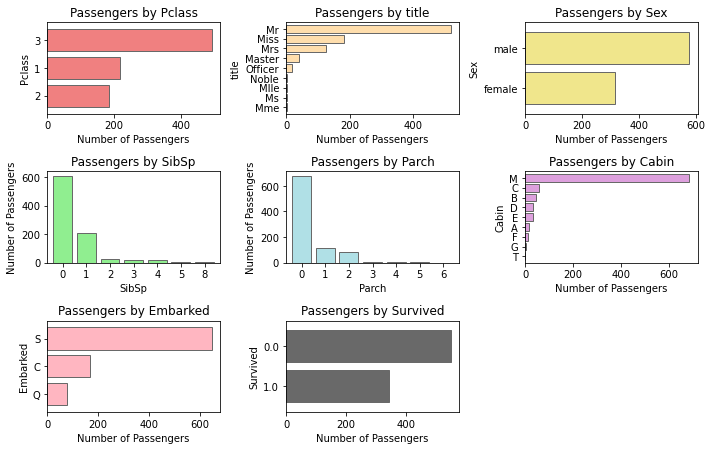

In [19]:
#visualize training data
features = ['Pclass','title','Sex','SibSp','Parch','Cabin','Embarked','Survived']
colors = ['lightcoral','navajowhite','khaki','lightgreen','powderblue','plum','lightpink','dimgray']
visualize_passengers(data[data.Survived.isna()==0],features,colors)

Embarked
Q     42.166667
C     93.500000
S    247.500000
dtype: float64

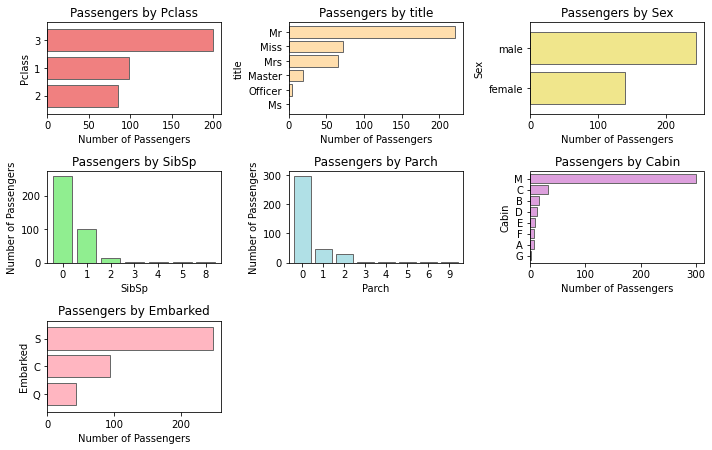

In [20]:
#visualize test data
features = ['Pclass','title','Sex','SibSp','Parch','Cabin','Embarked']
colors = ['lightcoral','navajowhite','khaki','lightgreen','powderblue','plum','lightpink']
visualize_passengers(data[data.Survived.isna()],features,colors)

What we see from the plots above is that the passenger characteristics seem fairly similar across both the training and test sets. Some general observations:
* Most passengers are male
* Most passengers are Pclass 3 (lowest class)
* Most passengers have no siblings/spouses/parents/children aboard, meaning they are travelling alone
* Most passengers are Cabin M, meaning their cabin information was not provided
* Most passengers embarked from Southampton

Now we need to explore the relationship between all these variables and passenger survival:

In [21]:
#calculate correlation between all variables
correlations = data[data.Survived.isna()==0][['Survived','Pclass','Sex','Age','SibSp','Parch',\
                                           'Fare']].corr()

#create a dataframe that sorts variables by how well-correlated they are to the 'Survived' target feature
ordered_correlations = pd.DataFrame(correlations.Survived).sort_values(by='Survived')

Text(0.5, 1.0, 'Correlation of Raw Numerical Features')

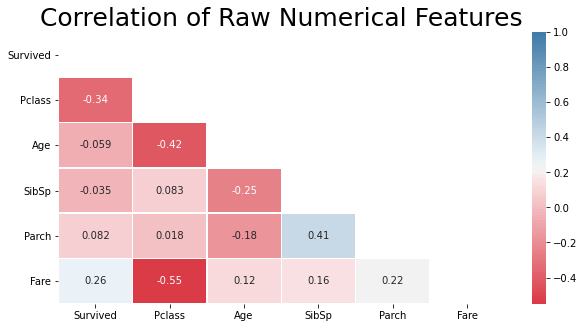

In [22]:
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize=(10,5))
corr_plot = sns.heatmap(correlations,annot = True,cmap = sns.diverging_palette(10,240, n=100),\
                        cbar = True,mask = mask, linewidth = 0.5)
plt.yticks(rotation = 0)
plt.title('Correlation of Raw Numerical Features',fontsize = 25)

The heatmap above is a great tool to see correlation between variables, but we can focus specifically on visualizing the correlation of the variables with the target '**Survived**' variable:

Text(0.5, 1.0, 'Correlation of Features with Passenger Survival\n')

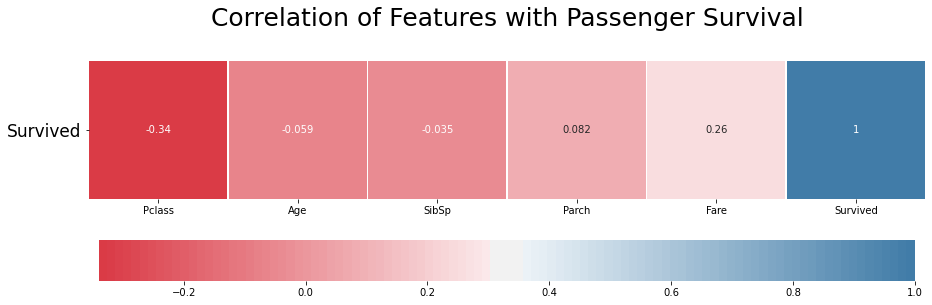

In [23]:
plt.subplots(figsize=(15,5))
corr_plot = sns.heatmap(ordered_correlations.transpose(),annot = True,cmap = sns.diverging_palette(10,240, n=100),\
                        cbar_kws = dict(use_gridspec=False,location="bottom"),\
                        cbar = True,square = True,linewidth = 0.5)
plt.yticks(rotation = 0, fontsize = 17)
plt.title('Correlation of Features with Passenger Survival\n',fontsize = 25)

From the plot above, it looks like **Pclass** and **Fare** are well correlated to survival. But this plot fails to show us how categorical variables relate to passenger survival. So here are more visualizations:

In [24]:
def survivor_histogram(df,features):
    """This function counts the number of passengers for each 
    feature and generates a graph to visualize the survivors vs non-survivors."""
    plt.figure(figsize = [15,15])
    
    for i in range(0,len(features)):
        plt.subplot(3,3,i+1)
        sns.countplot(features[i],hue='Survived',data=data, palette = 'RdYlGn'\
                     ,edgecolor = 'dimgrey')
        plt.xticks(rotation = 0)
        plt.ylabel('Number of Passengers')
        plt.title('Survivorship by {}'.format(features[i]))
        plt.legend(loc='upper right')
        plt.tight_layout()
    return plt.show()

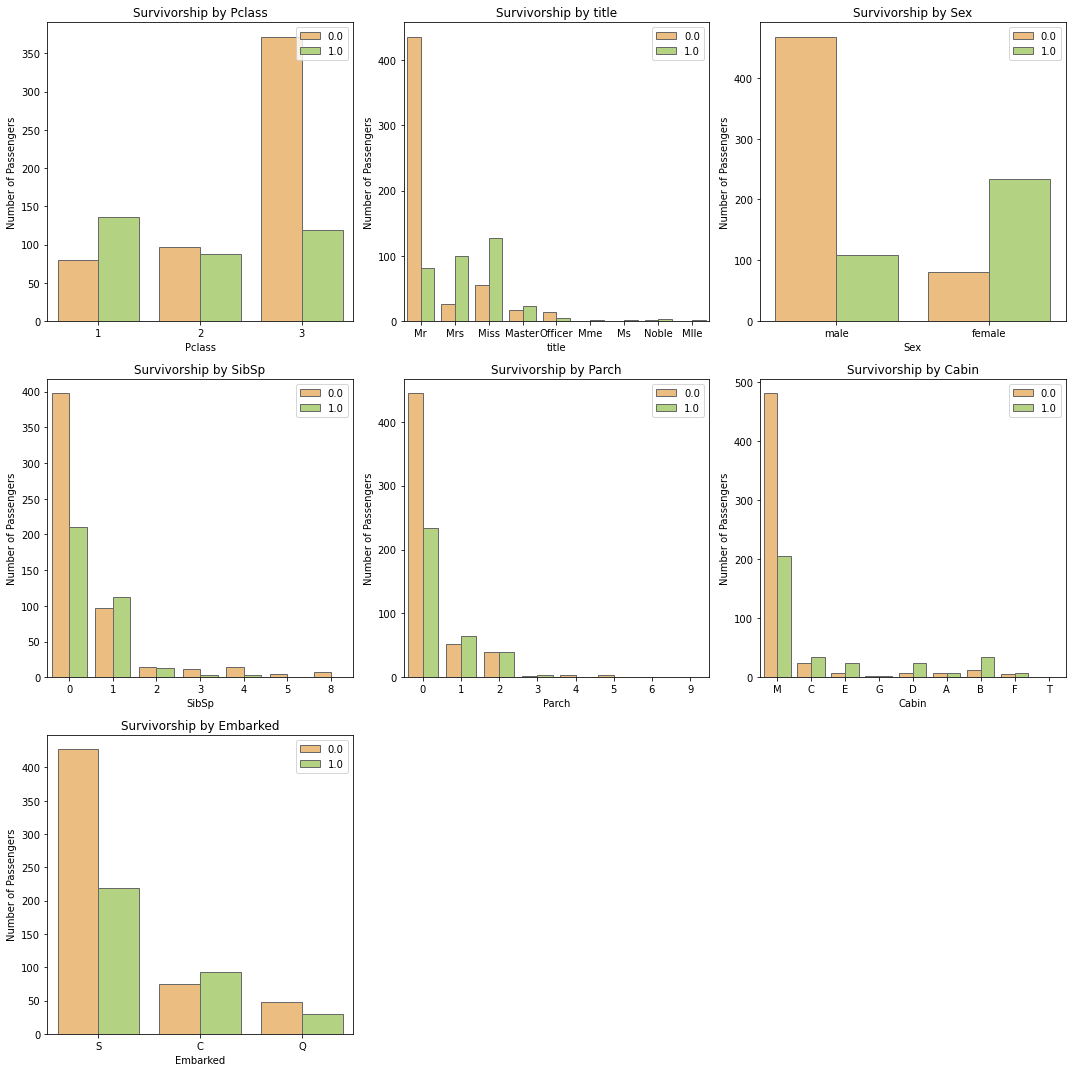

In [25]:
#visualize survivors by feature for training data
features = ['Pclass','title','Sex','SibSp','Parch','Cabin','Embarked']
survivor_histogram(data[data.Survived.isna()==0],features)

Some takeaways from the above histograms:
* 1st class passengers have the highest survival rate
* Passengers with Mrs, Ms, Miss etc. (ie. women) have very high survival rates. Masters (boys) also have high survival rates
* Men have very low survival rates
* Passengers without siblings, spouses, chldren, or parents onboard (ie. solo travellers) have low survival rates
* Certain cabins (D,E,B) have noticeably higher survival rates than other cabins
* Passengers embarking from Cherbourg have a better survival rate compared to other points of embarkment

Continuing with the visualization, let's look at the distribution of continuous variables (age and ticket fare):

Text(0.5, 1.0, 'Age Distribution of Passengers')

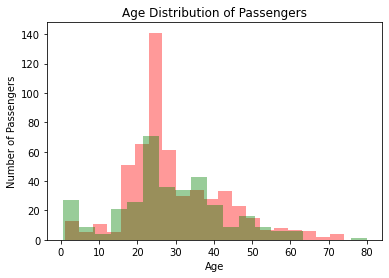

In [26]:
sns.distplot(data[data.Survived==0].Age,color='r', kde = False)
sns.distplot(data[data.Survived==1].Age,color='g', kde = False)
plt.ylabel('Number of Passengers')
plt.title('Age Distribution of Passengers')

Text(0.5, 1.0, 'Fare Distribution of Passengers')

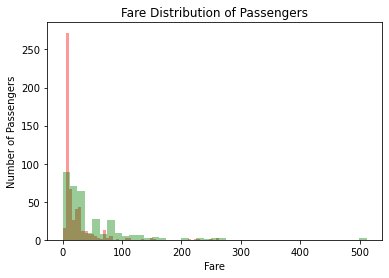

In [27]:
sns.distplot(data[data.Survived==0].Fare,color='r', kde = False)
sns.distplot(data[data.Survived==1].Fare,color='g', kde = False)
plt.ylabel('Number of Passengers')
plt.title('Fare Distribution of Passengers')

Takeaways from the distribution plots above:
* Young passengers have a higher survival rate
* Low fare seems to result in low survival. This is logical, as higher class / more important passengers would pay higher fares

There is another way we can visualize data, to get a better sense of the actual rates of survival:

In [28]:
def visualize_survivorship(df,features):
    """This function calculates the survivorship percentage for each categorical 
    feature and generates a graph to visualize this data. 
    It does this by creating a dataframe for each feature, and sorts the dataframe 
    in descending order, which makes visualization easier"""
    sorted_dict = {}
    plt.figure(figsize = [15,10])
    
    for i in range(0,len(features)):
        sorted_dict.update({'Survived':(df.groupby(['{}'.format(features[i])]).Survived.mean())})
        sorted_df = pd.DataFrame(sorted_dict).sort_values(by = 'Survived',ascending = False)
        plt.subplot(5,3,i+1)
        sns.barplot(sorted_df.index,'Survived',data=sorted_df, palette = 'Greens_d',\
                   edgecolor = 'dimgrey')
        plt.title('Survivorship Percentage based on {}'.format(features[i]))
        plt.tight_layout()
    return sorted_df

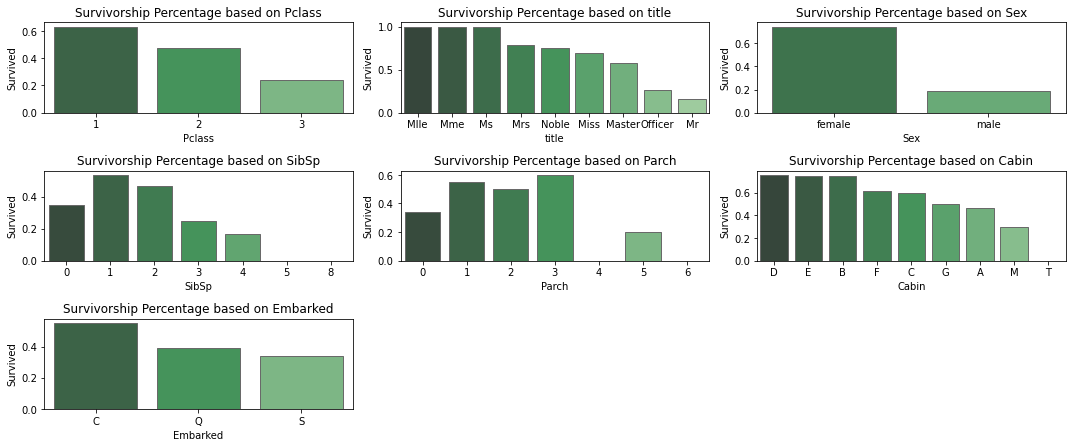

In [29]:
features1=['Pclass','title','Sex','SibSp','Parch','Cabin','Embarked']
visualize1=visualize_survivorship(data[data.Survived.isna()==0],features1)

The bar plots above confirm our inferences from the previous plots, but present a more digestable visual that indicates survival rates of different variables, rather than showing the absolute count of survivors/non-survivors. 

#### Model Attempt 1:
At this stage in my first attempt at this competition, I created a machine learning (ML) model without doing anything else. I had only taken IBM's Data Science specialization on Coursera, so I didn't have a great understanding of Python and the common ML libraries (NOTE: I do realize that my understanding is still VERY RUDIMENTARY). 

Without working any more with the dataset, I normalized/scaled the data, and threw a bunch of algorithms at it. That got me a score of *76*% (~18,000th of ~23,000 teams). 
This first pass at the model can be found here: https://www.kaggle.com/bethecheng/titanic-ml-competition-take-1

I realized I was still missing a bunch of skills/knowledge to handle this problem, so I took a break from Kaggle, and enrolled in Andrew Ng's Machine Learning MOOC.

#### Evaluation 1:

After completing the MOOC, I had learned a bit about model evaluation, and diagnosing bias/variance. I plotted the learning curves for this very basic model, and realized the model was underfit (high bias). 
You can check out the learning curves and the rest of the notebook here: https://www.kaggle.com/bethecheng/titanic-ml-competition-take-2

To correct the underfit model, I set out to add some features...I will discuss model evaluation and high bias/variance in the **Modeling** section of this notebook.
# 2 Feature Engineering:


## 2.1 Feature Creation:
Initally, I created a host of new features, some more meaningful than others. The features that remain in this notebook are left over from what I felt were the most effective and logical features.

In [30]:
#add a feature that counts how many family members a given passenger has onboard
data['Family'] = data['SibSp'] + data['Parch'] 

#add a feature to count how many times a given ticket appears.
#this is a useful feature to gauge passengers who were not travelling alone, but didn't necessary have family onboard
#(ie. Passengers with maids)
tickets = list(set(data.Ticket))
data['TicketFreq'] = [(list(data.Ticket).count(ticket)) for ticket in data.Ticket]

#add a feature for married women
data['Married'] = [1 if title == 'Mrs' else 0 for title in data.title]

It would be extremely useful to know how many of passenger's family members or travel companions (ie. same ticket number) survived. This feature that helps connect the training set to the test set through the passenger surnames or the ticket number. If we are predicting the survival of a passenger in the test set, knowing how many of his family members and/or travel companions survived is very useful. To create features that convey this information will take a bit of work:

In [31]:
#split Name feature to isolate the surname of each passenger
data['surname'] = data.Name.apply(lambda x: x.split(',')[0].strip())

In [32]:
#filter for unique surnames in the training set
training_names = data[data.Survived.isna()==0].surname.unique()

#filter for unique surnames in the test set
test_names = data[data.Survived.isna()].surname.unique()

#find the surnames that appear in both the training and test set
common_names = [name for name in training_names if name in test_names]

#find the names that appear exclusively in the training set
training_only_names = [name for name in training_names if name not in common_names]

#find the names that appear exclusively in the test set
test_only_names = [name for name in test_names if name not in common_names]

In [33]:
#calculate the mean survival rate for passengers in the training set
mean_survival_rate = np.mean(data[data.Survived.isna() == 0].Survived)

In [34]:
#filter for families that have more than 1 member, and calculate the survival rate for each of those families
family_survival_rates = data[data.Family>0].groupby('surname').Survived.mean()

#fill NaN values with 0 for familes where the mean was not computable
family_survival_rates = family_survival_rates.fillna(0)


famsurv = []
famsurvna = []

#loop through passengers, and if their surname is in both the training and test sets, assign the corresponding
#family survival rate.
for name in data.surname:
    if name in list(family_survival_rates.index) and name in common_names:
        famsurv.append(family_survival_rates[name])
        famsurvna.append(0)
    else:
        #if the passenger surname is not in both the training and test set, assign them the mean survival rate
        famsurv.append(mean_survival_rate)
        famsurvna.append(1)

#add the calculated family survival rates to the main dataframe
data['famsurv'] = famsurv
data['famsurvNA'] = famsurvna
data[data.famsurv==mean_survival_rate]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,Family,TicketFreq,Married,surname,famsurv,famsurvNA
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,M,S,Mr,1,1,0,Braund,0.383838,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,M,S,Miss,0,1,0,Heikkinen,0.383838,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,Mrs,1,2,1,Futrelle,0.383838,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,M,S,Mr,0,1,0,Allen,0.383838,1
5,6,0.0,3,"Moran, Mr. James",male,25.0,0,0,330877,8.4583,M,Q,Mr,0,1,0,Moran,0.383838,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303,1304,NaN,3,"Henriksson, Miss. Jenny Lovisa",female,28.0,0,0,347086,7.7750,M,S,Miss,0,1,0,Henriksson,0.383838,1
1304,1305,NaN,3,"Spector, Mr. Woolf",male,25.0,0,0,A.5. 3236,8.0500,M,S,Mr,0,1,0,Spector,0.383838,1
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,C,Miss,0,3,0,Oliva y Ocana,0.383838,1
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,M,S,Mr,0,1,0,Saether,0.383838,1


In [35]:
#filter for unique ticket numbers in the training set
training_tickets = list(set(data[data.Survived.isna()==0].Ticket))

#filter for unique ticket numbers in the test set
test_tickets = list(set(data[data.Survived.isna()].Ticket))

#find ticket numbers that appear in both the training and test set
common_tickets = [ticket for ticket in training_tickets if ticket in test_tickets]

#find ticket numbers exclusive to the training set
training_only_tickets = [ticket for ticket in training_tickets if ticket not in common_tickets]

#find ticket numbers exclusive to the test set
test_only_tickets = [ticket for ticket in test_tickets if ticket not in common_tickets]

In [36]:
#for ticket numbers that appear more than once, calculate the survival rate for each ticket number
ticket_survival_rates = data[data.TicketFreq>1].groupby('Ticket').Survived.mean()

##fill NaN values with 0 for ticket numbers where the mean was not computable
ticket_survival_rates = ticket_survival_rates.fillna(0)

ticksurv = []
ticksurvna = []

#loop through passengers, and if their ticket number is in both the training and test sets, assign the corresponding
#ticket survival rate.
for ticket in data.Ticket:
    if ticket in list(ticket_survival_rates.index) and ticket in common_tickets:
        ticksurv.append(ticket_survival_rates[ticket])
        ticksurvna.append(0)
    else:
        #if the passenger ticket number is not in both the training and test set, assign them the mean survival rate
        ticksurv.append(mean_survival_rate)
        ticksurvna.append(1)

#add calculated ticket survival rates back to the main dataframe
data['ticksurv'] = ticksurv
data['ticksurvNA'] = ticksurvna
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,title,Family,TicketFreq,Married,surname,famsurv,famsurvNA,ticksurv,ticksurvNA
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,Mr,1,1,0,Braund,0.383838,1,0.383838,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,Mrs,1,2,1,Cumings,1.000000,0,1.000000,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,Miss,0,1,0,Heikkinen,0.383838,1,0.383838,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,S,Mrs,1,2,1,Futrelle,0.383838,1,0.383838,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,S,Mr,0,1,0,Allen,0.383838,1,0.383838,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,25.0,0,0,A.5. 3236,8.0500,...,S,Mr,0,1,0,Spector,0.383838,1,0.383838,1
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,...,C,Miss,0,3,0,Oliva y Ocana,0.383838,1,0.500000,0
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,...,S,Mr,0,1,0,Saether,0.383838,1,0.383838,1
1307,1308,NaN,3,"Ware, Mr. Frederick",male,25.0,0,0,359309,8.0500,...,S,Mr,0,1,0,Ware,0.383838,1,0.383838,1


In [37]:
#average the family survival rate and the ticket survival rate to reduce dimensionality of data
data['survrate'] = round(((data['famsurv'] + data['ticksurv']) / 2),2)
data['survrateNA'] = round(((data['famsurvNA'] + data['ticksurvNA']) / 2), 2)
data.sample(7)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Family,TicketFreq,Married,surname,famsurv,famsurvNA,ticksurv,ticksurvNA,survrate,survrateNA
1003,1004,NaN,1,"Evans, Miss. Edith Corse",female,36.0,0,0,PC 17531,31.6792,...,0,1,0,Evans,0.383838,1,0.383838,1,0.38,1.0
300,301,1.0,3,"Kelly, Miss. Anna Katherine ""Annie Kate""",female,22.0,0,0,9234,7.7500,...,0,1,0,Kelly,0.383838,1,0.383838,1,0.38,1.0
369,370,1.0,1,"Aubart, Mme. Leontine Pauline",female,24.0,0,0,PC 17477,69.3000,...,0,2,0,Aubart,0.383838,1,0.383838,1,0.38,1.0
927,928,NaN,3,"Roth, Miss. Sarah A",female,22.0,0,0,342712,8.0500,...,0,1,0,Roth,0.383838,1,0.383838,1,0.38,1.0
454,455,0.0,3,"Peduzzi, Mr. Joseph",male,25.0,0,0,A/5 2817,8.0500,...,0,1,0,Peduzzi,0.383838,1,0.383838,1,0.38,1.0
331,332,0.0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,...,0,1,0,Partner,0.383838,1,0.383838,1,0.38,1.0
193,194,1.0,2,"Navratil, Master. Michel M",male,3.0,1,1,230080,26.0000,...,2,3,0,Navratil,0.383838,1,0.383838,1,0.38,1.0


#### Modeling Attempt 2:
After creating all those new features (and a couple ones that I removed from this notebook), I tried modeling again. Creating so many new features led to a high variance model (overfit). You can check out my overfit models here: https://www.kaggle.com/bethecheng/titanic-ml-competition-take-3. My overfit models didn't perform much better than my initial attempt at the problem. Throwing some high power algorithms like Random Forests at the data only got me a score of *78*%. A slight improvement, but still not quite satisfying...

## 2.2 Binning / Bucketing Features:
Part of the solution to address this overfitting was to bin our features to reduce the variance within these features. The visualizations made in "**Data Visualization 1**" provide insight into how we might bin our variables.

In [38]:
#combine female passenger titles together. High survival rates across all passengers with these titles
data.title = data.title.replace(['Mlle','Mme','Ms','Miss','Mrs'],'Ms/Mrs')

In [39]:
#bucket cabins together that had similar survival rates
data.Cabin = data.Cabin.replace(['D','E','B'],'DEB')
data.Cabin = data.Cabin.replace(['F','C','G','A'],'FCGA')
data.Cabin = data.Cabin.replace(['M','T'],'M')

In [40]:
#bucket family sizes into 0 (traveller was alone), small families (1-3 people), and large families (>3 people)
for i in range(0,len(data.Family)):
    if data.Family[i] == 0:
        data.Family[i] = 0
    elif data.Family[i] <=3 and data.Family[i] > 0:
        data.Family[i] = 1
    else:
        data.Family[i] = 2

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
#use qcut() function discretize age/fare data into equal-sized buckets
data.Age = pd.qcut(data.Age,7,precision=1,duplicates='drop')
data.Fare = pd.qcut(data.Fare,4,precision=2)

The qcut() method was great to bucket the continuous variables into equally sized groups. Binning the data this way highlighted the fact that young passengers, and passengers that paid a higher ticket fare were more likely to survive, as we will see in the visualizations below.

## 2.3 Data Visualization 2:
Now that we've added a few more features, and modified some of the existing features, we can perform more visualizations.

Text(0.5, 1.0, 'Survivor Count by Age Bucket')

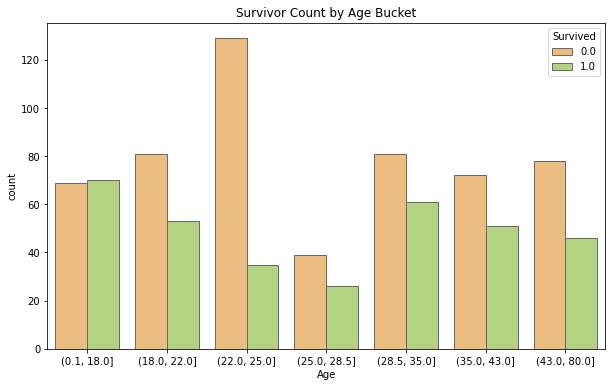

In [42]:
fig, axs = plt.subplots(figsize=(10, 6))
sns.countplot(x='Age',hue='Survived',data=data, palette = 'RdYlGn',edgecolor='dimgrey')
plt.title('Survivor Count by Age Bucket')

Text(0.5, 1.0, 'Survivor Count by Fare Bucket')

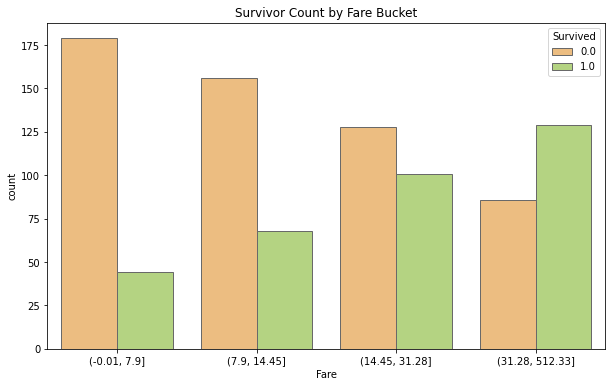

In [43]:
fig, axs = plt.subplots(figsize=(10, 6))
sns.countplot(x='Fare',hue='Survived',data=data, palette = 'RdYlGn',edgecolor='dimgrey')
plt.title('Survivor Count by Fare Bucket')

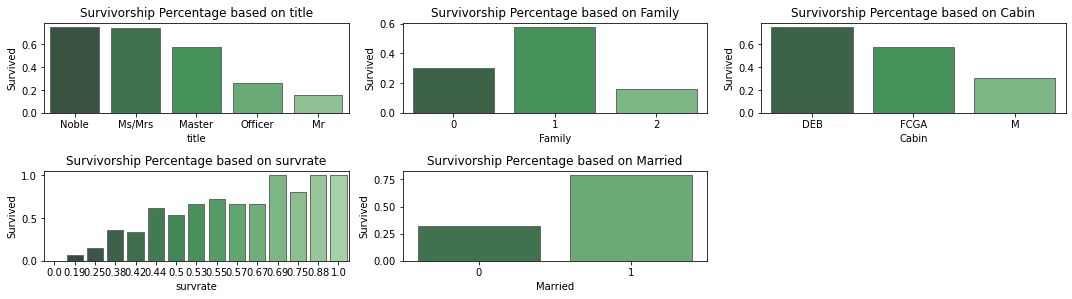

In [44]:
#visualize survivorship rates of new features
features=['title','Family','Cabin','survrate','Married']
testdf=visualize_survivorship(data[data.Survived.isna()==0],features)

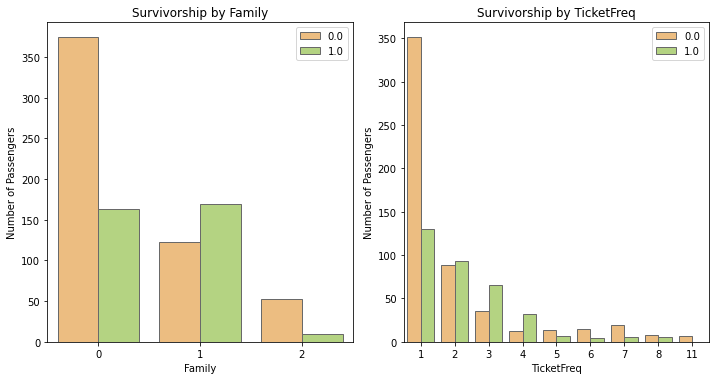

In [45]:
features = ['Family','TicketFreq']
survivor_histogram(data[data.Survived.isna()==0],features)

# 3. Final Clean-Up / Munging Before Modeling:

In [46]:
#drop features that are no longer needed (we used these features as stepping stones to other features)
data = data.drop(['SibSp','Parch','surname','famsurvNA','famsurv','ticksurvNA','ticksurv'],axis = 1)
data.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,title,Family,TicketFreq,Married,survrate,survrateNA
435,436,1.0,1,"Carter, Miss. Lucile Polk",female,"(0.1, 18.0]",113760,"(31.28, 512.33]",DEB,S,Ms/Mrs,1,4,0,0.38,1.0
379,380,0.0,3,"Gustafsson, Mr. Karl Gideon",male,"(18.0, 22.0]",347069,"(-0.01, 7.9]",M,S,Mr,0,1,0,0.38,1.0
999,1000,NaN,3,"Willer, Mr. Aaron (Abi Weller"")""",male,"(22.0, 25.0]",3410,"(7.9, 14.45]",M,S,Mr,0,1,0,0.38,1.0


## 3.1 Encoding Categorical Features:
We need to encode the categorical features into numerical features so that they can be processed by our model.

Note there are two types of encoding: 
1. **Label encoding**: converts string data into numerical data by assigning a unique number to each label. 
2. **One hot encoding**: splits categorical data into multiple columns, where each column contains only 1's or 0's to signify if that data sample has that particular categorical attribute.

In my earlier attempts at the project, I made the mistake of using **label encoding** for all my variables, without realizing that each encoding technique is best suited for certain kinds of data.

**One hot encoding** should be used on categorical variables, where the numerical order has no significance. **Label encoding** should be used when the order and magnitude of number values is meaningful for your variable. Here's a super helpful article that articulates this idea better than I do: https://towardsdatascience.com/choosing-the-right-encoding-method-label-vs-onehot-encoder-a4434493149b

In [47]:
le = LabelEncoder()
binned_data = data.copy()

#label encode discretized age/fare features
binned_data.Age = le.fit_transform(binned_data.Age)
binned_data.Fare = le.fit_transform(binned_data.Fare)

#create list of categorical variables we want to one hot encode
categorical_features = ['Pclass','Sex','Cabin','Embarked','title','Family']

#use Pandas get_dummies() function to one hot encode categorical variables
catdf = pd.get_dummies(binned_data[categorical_features].astype(str))

catdf

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Cabin_DEB,Cabin_FCGA,Cabin_M,Embarked_C,Embarked_Q,Embarked_S,title_Master,title_Mr,title_Ms/Mrs,title_Noble,title_Officer,Family_0,Family_1,Family_2
0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0
1,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0
2,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0
3,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0
4,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0
1305,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0
1306,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0
1307,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0


In [48]:
#create dataframe of ordinal features
orddf = binned_data[['Age','Fare','TicketFreq']]

#create dataframe of ratio features
ratiodf = binned_data['survrate']

#create dataframe of other categorical variables that did not need to be one hot encoded with get_dummies()
catdf2 = binned_data[['survrateNA','Married']]

#concatenate our features into one dataframe
binned_data = pd.concat([binned_data[['Survived']],catdf,orddf,ratiodf,catdf2],axis=1)
binned_data

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Cabin_DEB,Cabin_FCGA,Cabin_M,Embarked_C,...,title_Officer,Family_0,Family_1,Family_2,Age,Fare,TicketFreq,survrate,survrateNA,Married
0,0.0,0,0,1,0,1,0,0,1,0,...,0,0,1,0,1,0,1,0.38,1.0,0
1,1.0,1,0,0,1,0,0,1,0,1,...,0,0,1,0,5,3,2,1.00,0.0,1
2,1.0,0,0,1,1,0,0,0,1,0,...,0,1,0,0,3,1,1,0.38,1.0,0
3,1.0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,4,3,2,0.38,1.0,1
4,0.0,0,0,1,0,1,0,0,1,0,...,0,1,0,0,4,1,1,0.38,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,0,0,1,0,1,0,0,1,0,...,0,1,0,0,2,1,1,0.38,1.0,0
1305,NaN,1,0,0,1,0,0,1,0,1,...,0,1,0,0,5,3,3,0.44,0.5,0
1306,NaN,0,0,1,0,1,0,0,1,0,...,0,1,0,0,5,0,1,0.38,1.0,0
1307,NaN,0,0,1,0,1,0,0,1,0,...,0,1,0,0,2,1,1,0.38,1.0,0


In [49]:
binned_data.columns

Index(['Survived', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female',
       'Sex_male', 'Cabin_DEB', 'Cabin_FCGA', 'Cabin_M', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'title_Master', 'title_Mr', 'title_Ms/Mrs',
       'title_Noble', 'title_Officer', 'Family_0', 'Family_1', 'Family_2',
       'Age', 'Fare', 'TicketFreq', 'survrate', 'survrateNA', 'Married'],
      dtype='object')

In [50]:
#separate dataframe into training and test sets
training_set = binned_data[binned_data.Survived.isna()==0]

test_set = binned_data[binned_data.Survived.isna()].drop(['Survived'],axis=1)

In [51]:
training_set

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Cabin_DEB,Cabin_FCGA,Cabin_M,Embarked_C,...,title_Officer,Family_0,Family_1,Family_2,Age,Fare,TicketFreq,survrate,survrateNA,Married
0,0.0,0,0,1,0,1,0,0,1,0,...,0,0,1,0,1,0,1,0.38,1.0,0
1,1.0,1,0,0,1,0,0,1,0,1,...,0,0,1,0,5,3,2,1.00,0.0,1
2,1.0,0,0,1,1,0,0,0,1,0,...,0,1,0,0,3,1,1,0.38,1.0,0
3,1.0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,4,3,2,0.38,1.0,1
4,0.0,0,0,1,0,1,0,0,1,0,...,0,1,0,0,4,1,1,0.38,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,0,1,0,0,1,0,0,1,0,...,1,1,0,0,3,1,1,0.38,1.0,0
887,1.0,1,0,0,1,0,1,0,0,0,...,0,1,0,0,1,2,1,0.38,1.0,0
888,0.0,0,0,1,1,0,0,0,1,0,...,0,0,1,0,1,2,4,0.00,0.0,0
889,1.0,1,0,0,0,1,0,1,0,1,...,0,1,0,0,3,2,1,0.38,1.0,0


In [52]:
test_set

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Cabin_DEB,Cabin_FCGA,Cabin_M,Embarked_C,Embarked_Q,...,title_Officer,Family_0,Family_1,Family_2,Age,Fare,TicketFreq,survrate,survrateNA,Married
891,0,0,1,0,1,0,0,1,0,1,...,0,1,0,0,4,0,1,0.38,1.0,0
892,0,0,1,1,0,0,0,1,0,0,...,0,0,1,0,6,0,1,0.38,1.0,1
893,0,1,0,0,1,0,0,1,0,1,...,0,1,0,0,6,1,1,0.38,1.0,0
894,0,0,1,0,1,0,0,1,0,0,...,0,1,0,0,3,1,1,0.38,1.0,0
895,0,0,1,1,0,0,0,1,0,0,...,0,0,1,0,1,1,2,1.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,0,1,0,1,0,0,1,0,0,...,0,1,0,0,2,1,1,0.38,1.0,0
1305,1,0,0,1,0,0,1,0,1,0,...,0,1,0,0,5,3,3,0.44,0.5,0
1306,0,0,1,0,1,0,0,1,0,0,...,0,1,0,0,5,0,1,0.38,1.0,0
1307,0,0,1,0,1,0,0,1,0,0,...,0,1,0,0,2,1,1,0.38,1.0,0


Now we have fully numerical training and test sets we can use for modeling. Our training set has one extra column because it contains the target '**Survived**' variable.

# 4. Modeling:
I really focused on this portion of the data science methodology because I felt like there wasn't much attention given to it in other notebooks. I found it helpful to be able to diagnose how the models were performing, and how I could use that information to update my feature set and model.
## 4.1 Normalizing the Feature Set:
Normalization of the feature set is required to make sure that variables with different magnitudes are not treated differently. It's not a huge problem with this dataset, but imagine we had a feature that had a range of values from 0 - 10,000, and all the other features ranged only from 0 - 10. In that case, the classification algorithm would assign too much weight/importance to the feature with the large magnitude, and that variable would have too large of an impact on the model. Normalization helps mitigate this issue. 

In [53]:
#scale/normalize the training set
x_data = training_set.drop(['Survived'],axis=1)
X = preprocessing.StandardScaler().fit_transform(x_data)

#create target variable
y = training_set['Survived']

Now that our feature set is scaled/normalized, we can plug it into a model. We don't know what kind of classifier algorithm will work best, so let's just try logistic regression:

In [54]:
#trial run with a logistic regression model
lr_model = LogisticRegression(solver='liblinear')

#compute cross validation score for logistic regression model
lr_score = np.mean(cross_val_score(lr_model,X,y,scoring = 'accuracy'))
lr_score

0.8462117883372041

## 4.2 Selecting a Classfier Algorithm:
With an untuned logistic regression classifier, we are achieving a cross validation score of *84.6*%, which is encouraging. But it would be useful to compare a variety of ML models/algorithms without too much code. Here's a **brief** novice synopsis of each supervised learning (classification) algorithm we will be testing:

* **Logistic Regression**: uses a special mathematical function (the sigmoid function) to output a probability between 0 and 1 of whether or not a training example is classified positively. 
* **Support Vector Machines (SVMs)**: fits a hyperplane (decision boundary) between the positive and negative class in the dataset.
* **Decision Tree**: Splits data repeatedly based on features in the dataset to sort training examples into their positive/negative classes.
* **Random Forest**: An ensemble of decision trees, with very high computational power.

### 4.2.1 Parameter Tuning with GridSearchCV:
We will create a dictionary of different models and tuning parameters to pass to Scikit-learn's GridSearchCV module. The GridSearchCV module will iterate through all the different parameters we've given it for all the different classification algorithms. It will compute the cross validation score for each algorithm using the different combinations of parameters we've provided, and will return the best model for us to use, as well as the tuned parameters that optimize the performance of that model.

In [55]:
model_params = {
    'LogisticRegression':{
        'model':LogisticRegression(),
        'params':{
            'solver':['liblinear','lbfgs'], 
            'C':[0.01,0.1,0.5,0.75,1,10] #regularization parameter to dampen impact of features on model
        }
    },
    'svm':{
        'model':svm.SVC(),
        'params':{
            'kernel':['rbf','linear'],
            'C':[0.01,0.1,0.5,1,1.5,10]
        }
    },
    'decision_tree':{
        'model':DecisionTreeClassifier(),
        'params':{
            'criterion':['gini','entropy']
        }
    },
    'random_forest':{
        'model':RandomForestClassifier(),
        'params':{
            'n_estimators':[1,5,20,50,100,1000]
        }
    }
}

Some notes on the parameters we are asking GridSearchCV to iterate through:
* The **solver** parameter in logistic regression refers to the method by which the algorithm performs gradient descent to find the minima of the logistic regression cost function.  
* The **C** value (for both logistic regression and SVMs) is a regularization parameter. Regularization is a means of reducing the impact that a feature has on the algorithm by reducing the magnitude of the values in that feature. A low value of C (C < 1) indicates heavy regularization. Regularization is helpful to correct overfit (high variance) models.
* The **kernel** in SVMs is a function that is used to create a "similarity", which is a transformation of the original feature set. These kernels help SVMs learn complex, non-linear decision boundaries. A linear kernel is a fancy way of saying no kernel is being applied. An 'rbf' or radial basis function kernel is a common type of kernel, of which the most famous example is the Gaussian kernel.
* The **entropy** criterion for decision trees tells the algorithm to make splits in the data based on the purity of information that results from each split (ie. How cleanly does the split separate training examples into positive/negative classes?).
* As a machine learning novice, random forests are still a bit of black hole to me, so don't ask about **n_estimators** or any other random forest parameters...


In [56]:
scores = []

#loop through different ML models and return the parameters that yield the highest cross validation score for each model
for model_name,mp in model_params.items():
    clf = GridSearchCV(mp['model'],mp['params'],return_train_score = False)
    clf.fit(X,y)
    scores.append({
        'model':model_name,
        'best_score':clf.best_score_,
        'best_params':clf.best_params_
    })

In [57]:
#convert results from GridSearchCV into a dataframe
models_df = pd.DataFrame(scores)
models_df

,model,best_score,best_params
0,LogisticRegression,0.849576,"{'C': 0.1, 'solver': 'liblinear'}"
1,svm,0.851817,"{'C': 0.1, 'kernel': 'linear'}"
2,decision_tree,0.835026,{'criterion': 'gini'}
3,random_forest,0.841774,{'n_estimators': 100}


We've thrown four different classfiers at the dataset, and it looks like support vector machines (SVMs) are our best option, so we will fit a model that has had its parameters tuned for us by GridSearchCV. Note that the C parameter given to us by GridSearchCV is <1, which means we are regularizing the features, which indicates that our model was overfit.

In [58]:
#train SVM model using tuned parameters from GridSearchCV
svm_model = svm.SVC(C = 0.1, kernel = 'linear')
svm_model.fit(X,y)
           
#compute cross validation score
svm_cv_score = np.mean(cross_val_score(svm_model,X,y,scoring = 'accuracy'))
svm_cv_score

0.8518172117255665

Now that we've selected the best performing model based on cross-validation score, we need to evaluate the model to determine if any further refinements can be made.

### 4.3 Diagnosing Bias/Variance with Learning Curves:
#### 4.3.1 Underfit (High Bias) & Overfit (High Variance):
**Underfit (High Bias)**: Describes models that are too general/simplistic for the training dataset. Underfit models lack specificity to correctly model the training data, and also do not model the cross validation data well. Underfit models can be corrected by adding more features, and removing regularization parameters. 

**Overfit (High Variance)**: Describes models that fit the training set so well that they do not generalize well to data outside the training set. Overfit models can be corrected by reducing the number of features, increasing the amount of regularization, or by providing more training data to the model.

#### 4.3.2 Learning Curves:
We need to plot the **learning curves** for this model to diagnose if we have underfit/overfit the model. Scikit-learn has a learning_curve() module to help us. 
A **learning curve** is a graph of the training error and cross validation error plotted as a function of training set size. The idea is that a very small training set is easy to overfit (high cross validation error, low training error), but as we increase the training set size, if our model is well fit, the cross validation error will decrease, the training error will increase, and hopefully there will be a sort of convergence between the two errors. If we see the training and cross validation error converging at a very high error value, we know we have a high bias (underfit) model. If we see the training error remain low, and there is a large gap between the training and cross validation errors, even as the training set size increases, we know we have a high variance (overfit) model.

Here's a great tutorial on learning curves: https://www.dataquest.io/blog/learning-curves-machine-learning/

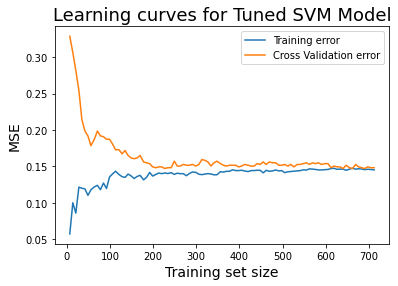

In [59]:
#create learning curves to diagnose bias/variance
train_sizes, train_scores, cv_scores = learning_curve(estimator = svm_model,X = X, y = y,shuffle = True, \
                                                     train_sizes = np.linspace(0.01,1,100),\
                                                         scoring = 'neg_mean_squared_error')

#compute mean scores for training and cross-validation set to generate learning curves
mean_train_score = train_scores.mean(axis = 1) * -1
mean_cv_score = cv_scores.mean(axis = 1) * -1

#plot learning curves
plt.plot(train_sizes, mean_train_score, label = 'Training error')
plt.plot(train_sizes, mean_cv_score, label = 'Cross Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for Tuned SVM Model', fontsize = 18)
plt.legend()

This learning curve seemed to be performing well. The training and cross validation error converged, but they converge at a fairly high value of mean squared error (MSE) which might indicate high bias (underfit). This could be due to the regularization parameter (C) that we tuned our model with. With this model, I was still only achieving a score of *78*%, which was not an improvement from my previous attempts. 

I continued modifying my model, adding features because the learning curves were indicating high bias. After submitting my model several times, and realizing that my performance on the test set was continuing to fall, I realized I was starting to overtrain the model. As my cross validation score improved (up to ~*89*%), my test scores fell to ~*73*%. It was clear to me my model was now overfit, so I set out to further refine the model.

As mentioned earlier, one technique to correct overfitting is to reduce the number of features. I will use Scikit-learn's SelectKBest module to help me choose which features are most important to the model. This will help me decide which features to keep.

## 4.4 Feature Selection with SelectKBest:
SelectKBest takes a score function parameter that it uses to evaluate which features are best for the model. I randomly started by selecting the best 5 features using an F-test as my scoring parameter. I tinkered with the k parameter, and found that **k = 14** parameters seemed to produce the best test score.

**F-test**: compares the variance between a given feature and the target, with the variance within the feature / target. A large F-statistic means the variance between groups is high, while the variance within groups is low. High between-group variance means that the variable has a strong impact on the model.
Here is a great tutorial on F-statistics: https://towardsdatascience.com/fisher-test-for-regression-analysis-1e1687867259

In [60]:
#define and fit selector object
selector = SelectKBest(f_classif, k=14)
selector.fit(X,y)

#get indices of best features
best_features = selector.get_support(indices = True)
best_features 

array([ 0,  2,  3,  4,  5,  7,  8, 12, 13, 16, 17, 20, 22, 24])

In [61]:
#get names of best performing features
x_data.columns[best_features]

Index(['Pclass_1', 'Pclass_3', 'Sex_female', 'Sex_male', 'Cabin_DEB',
       'Cabin_M', 'Embarked_C', 'title_Mr', 'title_Ms/Mrs', 'Family_0',
       'Family_1', 'Fare', 'survrate', 'Married'],
      dtype='object')

Now that we've determined our best features, we can reduce our feature set:

In [62]:
#reduce feature set
reduced_feat_set = x_data.iloc[:,best_features]

#normalize reduced feature set
X_reduced = preprocessing.StandardScaler().fit_transform(reduced_feat_set)

Now we have a reduced feature set, we can plug it back into GridSearchCV to see how our model should be re-tuned to optimize to the new feature set.

In [63]:
scores1 = []

#loop through different ML models and return the parameters that yield the highest cross validation score for each model
for model_name,mp in model_params.items():
    clf1 = GridSearchCV(mp['model'],mp['params'],return_train_score = False)
    clf1.fit(X_reduced,y)
    scores1.append({
        'model':model_name,
        'best_score':clf1.best_score_,
        'best_params':clf1.best_params_
    })

#convert results from GridSearchCV into a dataframe
models_df1 = pd.DataFrame(scores1)
models_df1

,model,best_score,best_params
0,LogisticRegression,0.841736,"{'C': 0.1, 'solver': 'lbfgs'}"
1,svm,0.848472,"{'C': 1, 'kernel': 'rbf'}"
2,decision_tree,0.840631,{'criterion': 'gini'}
3,random_forest,0.845126,{'n_estimators': 20}


Although GridSearchCV is telling us that a Random Forest classifier would perform slightly better, we will stick with SVMs because I understand them better. It's worth noting that we are not heavily regularizing the features in our new SVM model, and we are using an 'rbf' kernel in our SVM.

In [64]:
#get cross validation score for SVM model using reduced feature set
clf2 = svm.SVC(C = 1, kernel = 'rbf')

cv_score2 = np.mean(cross_val_score(clf2,X_reduced,y,scoring = 'accuracy'))
cv_score2

0.8484715334881677

Our cross validation score with the reduced feature set (14 features) is *84.8*%. Our cross validation score with the full feature set (25 features) was *85.2*%. So we've lost almost no performance, while managing to reduce our number of features by >*40*%! This not only hopefully solves our problem of overfitting, but also reduces compute time.

Let's examine the learning curves for the model using the reduced feature set:

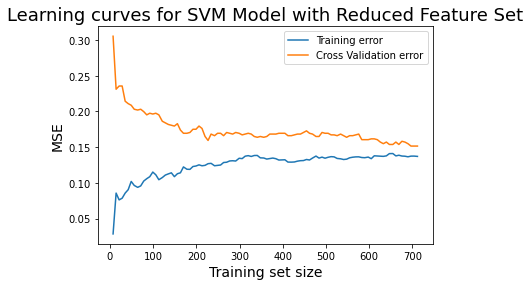

In [65]:
#create learning curves to diagnose bias/variance
train_sizes, train_scores, cv_scores = learning_curve(estimator = clf2,X = X_reduced, y = y,shuffle = True, \
                                                     train_sizes = np.linspace(0.01,1,100),\
                                                         scoring = 'neg_mean_squared_error')

#compute mean scores for training and cross-validation set to generate learning curves
mean_train_score = train_scores.mean(axis = 1) * -1
mean_cv_score = cv_scores.mean(axis = 1) * -1

#plot learning curves
plt.plot(train_sizes, mean_train_score, label = 'Training error')
plt.plot(train_sizes, mean_cv_score, label = 'Cross Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for SVM Model with Reduced Feature Set', fontsize = 18)
plt.legend()

This new learning curve looks pretty good, judging by the narrowing gap between the training and cross validation error. It still looks like the training and cross validation curves are convergent. One more technique we have to evaluate model performance is the ROC curve.

## 4.5 ROC Curves:
**ROC Curves**: A curve that shows the true positive rate and false positive rate as the threshold for classification of positive/negative class is varied. As you lower the threshold for positive classification (ie. make it easier for the model to predict a positive class), you improve your true positive rate, but your false positive rate also increases. Essentially, you are casting a wider net, so while you will catch more true positive values, you will also increase the likelihood that your model mistakes a negative class for a positive class. The vice is also versa. Increasing your threshold for positive classification (ie. making the model more selective about what it chooses to classify as a positive example) means that you will make more negative classifications, but your total number of true positive classifications will also decrease. You are tightening your net so that only examples you are very confident are positive will be classified as positive.  An ideal ROC curve hugs the top left corner of the graph as closely as possible. 

**AUC (Area Under the Curve)**: A perfect classifier algorithm would have an AUC = 1. 

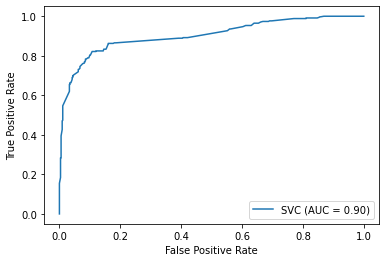

In [66]:
#plot ROC curve for SVM model
metrics.plot_roc_curve(clf2.fit(X_reduced,y), X_reduced, y)
plt.show() 

In [67]:
#test SVM model with reduced feature set:
test_set2 = test_set.iloc[:,best_features]
X_test2 = preprocessing.StandardScaler().fit(test_set2).transform(test_set2.astype(float))

#generate predictions for test set
yhat = clf2.fit(X_reduced,y).predict(X_test2).astype(int)

## 4.6 Submission:

In [68]:
#generate new dataframe with only test set PassengerId's and predicted survival classification
predicted = pd.DataFrame(data[data.Survived.isna()].PassengerId)
predicted['Survived'] = yhat

#export results to .csv file for submission without indices or headers
predicted.to_csv('/kaggle/working/titanic_results2.csv',index=False,header=True)
predicted.head(10)

,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1
896,897,0
897,898,1
898,899,0
899,900,1
900,901,0


There is a really interesting notebook on a rules-based classification model for this dataset: https://www.kaggle.com/c/titanic/discussion/57447. In the notebook, Chris Deotte provides two sample list of passengers from the test set: one list of men that survived the Titanic, and one list of women that did not survive. We will use these lists to do a quick visual inspection of how our model did on correctly making these predictions.

In [69]:
check = data[data.Survived.isna()].copy()
check['predicted'] = predicted.Survived
sample_men_live = [956,981,1053,1086,1088,1199,1284,1309]
sample_women_die = [910,925,929,1024,1032,1080,1172,1176,1257,1259]

In [70]:
#all the men in the table below survived the Titanic
check[check.PassengerId.isin(sample_men_live)]

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,title,Family,TicketFreq,Married,survrate,survrateNA,predicted
955,956,NaN,1,"Ryerson, Master. John Borie",male,"(0.1, 18.0]",PC 17608,"(31.28, 512.33]",DEB,C,Master,2,7,0,1.0,0.0,1
980,981,NaN,2,"Wells, Master. Ralph Lester",male,"(0.1, 18.0]",29103,"(14.45, 31.28]",M,S,Master,1,3,0,1.0,0.0,1
1052,1053,NaN,3,"Touma, Master. Georges Youssef",male,"(0.1, 18.0]",2650,"(14.45, 31.28]",M,C,Master,1,3,0,1.0,0.0,1
1085,1086,NaN,2,"Drew, Master. Marshall Brines",male,"(0.1, 18.0]",28220,"(31.28, 512.33]",M,S,Master,1,3,0,1.0,0.0,1
1087,1088,NaN,1,"Spedden, Master. Robert Douglas",male,"(0.1, 18.0]",16966,"(31.28, 512.33]",DEB,C,Master,1,5,0,1.0,0.0,1
1198,1199,NaN,3,"Aks, Master. Philip Frank",male,"(0.1, 18.0]",392091,"(7.9, 14.45]",M,S,Master,1,2,0,1.0,0.0,1
1283,1284,NaN,3,"Abbott, Master. Eugene Joseph",male,"(0.1, 18.0]",C.A. 2673,"(14.45, 31.28]",M,S,Master,1,3,0,0.5,0.0,1
1308,1309,NaN,3,"Peter, Master. Michael J",male,"(22.0, 25.0]",2668,"(14.45, 31.28]",M,C,Master,1,3,0,1.0,0.0,1


In [71]:
#all the women in the table below did not survive the Titanic
check[check.PassengerId.isin(sample_women_die)]

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,title,Family,TicketFreq,Married,survrate,survrateNA,predicted
909,910,NaN,3,"Ilmakangas, Miss. Ida Livija",female,"(25.0, 28.5]",STON/O2. 3101270,"(7.9, 14.45]",M,S,Ms/Mrs,1,1,0,0.19,0.5,0
924,925,NaN,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",female,"(18.0, 22.0]",W./C. 6607,"(14.45, 31.28]",M,S,Ms/Mrs,1,4,1,0.00,0.0,0
928,929,NaN,3,"Cacic, Miss. Manda",female,"(18.0, 22.0]",315087,"(7.9, 14.45]",M,S,Ms/Mrs,0,1,0,0.38,1.0,1
1023,1024,NaN,3,"Lefebre, Mrs. Frank (Frances)",female,"(18.0, 22.0]",4133,"(14.45, 31.28]",M,S,Ms/Mrs,2,5,1,0.00,0.0,0
1031,1032,NaN,3,"Goodwin, Miss. Jessie Allis",female,"(0.1, 18.0]",CA 2144,"(31.28, 512.33]",M,S,Ms/Mrs,2,8,0,0.00,0.0,0
1079,1080,NaN,3,"Sage, Miss. Ada",female,"(18.0, 22.0]",CA. 2343,"(31.28, 512.33]",M,S,Ms/Mrs,2,11,0,0.00,0.0,0
1171,1172,NaN,3,"Oreskovic, Miss. Jelka",female,"(22.0, 25.0]",315085,"(7.9, 14.45]",M,S,Ms/Mrs,0,1,0,0.38,1.0,1
1175,1176,NaN,3,"Rosblom, Miss. Salli Helena",female,"(0.1, 18.0]",370129,"(14.45, 31.28]",M,S,Ms/Mrs,1,3,0,0.00,0.0,0
1256,1257,NaN,3,"Sage, Mrs. John (Annie Bullen)",female,"(18.0, 22.0]",CA. 2343,"(31.28, 512.33]",M,S,Ms/Mrs,2,11,1,0.00,0.0,0
1258,1259,NaN,3,"Riihivouri, Miss. Susanna Juhantytar Sanni""""",female,"(18.0, 22.0]",3101295,"(31.28, 512.33]",M,S,Ms/Mrs,0,7,0,0.19,0.5,0


As we can see from the sample tables above, the model isn't doing too bad! It correctly predicts that all 8 of the men survive, and it correctly predicts 8/10 non-survivals amongst the women listed.

# 5. Conclusion:
My highest test score is *80.1*%! My goal was to score over 80%, so I'm very happy that I've achieved my goal! I tried the chronicle the path I took to solve this problem, and the tools I used to evaluate my model along the way. This was my no means a linear progression, and I hope that I highlighted my struggles in a way that helps other beginners diagnose their models. Thanks for reading!

-**Evan Cheng**